In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../src')

In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering,adaptive_box, adaptive_box2
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend

In [7]:
pd.set_option("display.max_columns", None)

### Directory to save figures

In [8]:
save = False
path_figs = './figs/2Mstd5/With_EFF_CALC'
Path(path_figs).mkdir(exist_ok = True, parents = True)

### Generate Experiment

In [9]:
%%time

N,D = 2*10**6, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.5,0.5],[0.5,0.5]]
r_small = [0, 0.3241]
r_big = [0.3241,0.4583]
eligibilities = [2,1]
kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
               'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                  [2, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:1369, Number of Points:2000000
CPU times: user 1.27 s, sys: 431 ms, total: 1.7 s
Wall time: 1.67 s


### Apply box clustering to use for the adaptive algorithm

In [10]:
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )

In [11]:
data.head(3)

,x0,x1,C,Treatment,Y,Ycf,ITE,Box-Cluster
0,0.548814,0.715189,2,0,-4.801753,6.588540,11.390293,982
1,0.602763,0.544883,2,0,-7.216687,-0.033002,7.183685,762
2,0.423655,0.645894,2,0,-4.442581,3.905554,8.348135,866


In [12]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

In [13]:
#threshold

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'weight')

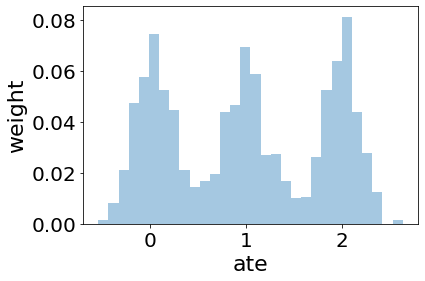

In [14]:
kde = False
bins = 30
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, hist_kws = {'weights':box['Box-Weights'].values} , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')

In [15]:
from clustering_algos import opt_kmeans, backtrack


In [16]:
def optimal_clustering(data, max_clusters=7, threshold = 0.5,  cluster_name = 'Optimal-Cluster',
                       col_select=None, fit_kwargs = {}, N = 100, **kwargs):
    """
    1-D optimal clustering
    data: pandas arrays with column to perform the optimal 1 d clustering
    max_clusters: maximum number of clusters optimal clustering to consider
    threshold: where to stop optimal clustering (preseted for our problem)
    cluster_name: how to name the new column with clustering
    col_select: col name to perform clustering
    fit_kwargs: not used just for framework consistency
    N: number of datapoints for pre setted threshold
    **kwargs: not used just for framewrok consistency
    """
    
    #presetted threshold for our problem
    threshold = 3.8*np.log(N)/np.sqrt(N)
    
    #sort data by the column to cluster 
    data = data.sort_values(by= col_select)
    values = data[col_select].values
    index = np.array(data.index)
    
    #perform optimal kmeans
    D,B = opt_kmeans(values, max_clusters)
    D = D/np.sqrt(N)
    
    #find the optimal cluster number
    opt_clust = 0
    for k in range(max_clusters):
        if D[-1,k] <= threshold:
            opt_clust = k+1
            break
    if opt_clust != 3:
        print('Did not pick 3, it picked:', opt_clust)
        opt_clust = 3
    #find the intervals of the clusters
    intervals = backtrack(B, len(values), opt_clust)
    
    #calculate the means and the indexes correspodning in each cluster
    means = []
    indx_class = {}
    class_counter = 0
    for i in range(1,len(intervals)):
        mu = np.mean(values[int(intervals[i-1]):int(intervals[i])])
        indxs = index[int(intervals[i-1]):int(intervals[i])]
        indx_class[class_counter] = indxs
        class_counter += 1
        means.append(mu)
        
    #assign cluster indexes to datapoints
    data[cluster_name] = 0
    for key, val in indx_class.items():
        data.loc[val, cluster_name] = key
    #reset data index
    data = data.reset_index(drop = True)  
    return data, np.array(means)

In [17]:
data, means = optimal_clustering(box.copy(), col_select = 'Box-ATT', N = N )
data2, means2 = kmeans_clustering(box.copy(), clusters = len(means), col_select = ['Box-ATT'], )

Did not pick 3, it picked: 4


In [18]:
data.groupby('Optimal-Cluster').mean()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
Optimal-Cluster,,,,,
0,685.245763,0.041715,1460.487288,0.962786,0.000730
1,677.476510,0.995978,1461.803132,0.948263,0.000731
2,689.173333,1.988857,1460.497778,0.982214,0.000730


In [19]:
means.reshape(3,1)

array([[0.0417153 ],
       [0.99597753],
       [1.98885728]])

In [20]:
data2.groupby('Kmeans-Cluster').mean()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
Kmeans-Cluster,,,,,
0,685.245763,0.041715,1460.487288,0.962786,0.000730
1,677.476510,0.995978,1461.803132,0.948263,0.000731
2,689.173333,1.988857,1460.497778,0.982214,0.000730


In [21]:
means2.cluster_centers_

array([[0.04275787],
       [0.99701145],
       [1.98885728]])